<a href="https://colab.research.google.com/github/YassineNajar/Examen_TP/blob/main/Fake_Reviews_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=bc56ffa2c17ec6af517042f8ef33ae035585f4fa15054e2ed397d76f89b214fb
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [2]:
# Jupyter Notebook: Fake Reviews Detection
# Course: Machine Learning, IIA4, 2024/2025
# Dataset: Fake Reviews Dataset

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
import nltk
import lime.lime_text
from lime.lime_text import LimeTextExplainer
import warnings
warnings.filterwarnings('ignore')

In [8]:
# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
 # Download the missing resource
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [4]:
# === 1. Data Preprocessing ===

# Load the dataset
df = pd.read_csv('/content/fake reviews dataset.csv')

In [5]:
# Rename columns for consistency
df.columns = ['category', 'rating', 'label', 'text']

# Encode labels: fake=0, real=1
df['label_encoded'] = df['label'].map({'CG': 0, 'OR': 1})

# Text cleaning function
def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

In [9]:
# Apply text cleaning
df['cleaned_text'] = df['text'].apply(clean_text)

# Initial statistical analysis
print("Dataset Info:")
print(df.info())
print("\nLabel Distribution:")
print(df['label'].value_counts())
print("\nRating Distribution:")
print(df['rating'].value_counts())

# Check for duplicates
duplicates = df.duplicated().sum()
print(f"\nNumber of duplicates: {duplicates}")
if duplicates > 0:
    df = df.drop_duplicates()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18211 entries, 0 to 18210
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   category       18211 non-null  object 
 1   rating         18211 non-null  float64
 2   label          18211 non-null  object 
 3   text           18211 non-null  object 
 4   label_encoded  18211 non-null  int64  
 5   cleaned_text   18211 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 853.8+ KB
None

Label Distribution:
label
CG    9109
OR    9102
Name: count, dtype: int64

Rating Distribution:
rating
5.0    11279
4.0     3340
3.0     1562
1.0     1142
2.0      888
Name: count, dtype: int64

Number of duplicates: 3


In [10]:
# Analyze review length
df['text_length'] = df['cleaned_text'].apply(lambda x: len(x.split()))
print("\nAverage review length by class:")
print(df.groupby('label')['text_length'].mean())


Average review length by class:
label
CG    24.058203
OR    34.160075
Name: text_length, dtype: float64


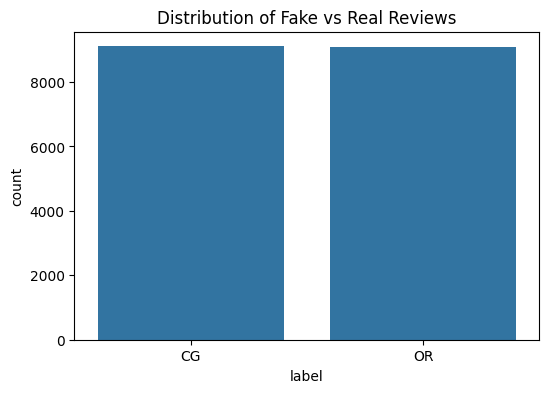

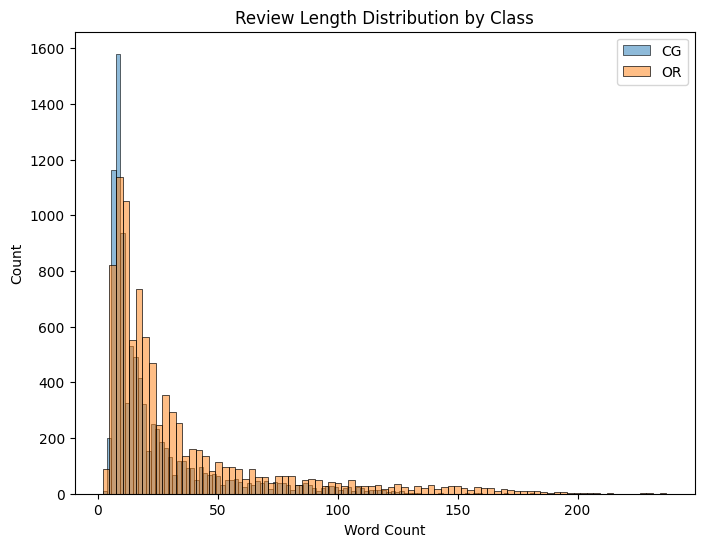

In [11]:
# === 2. Exploratory Data Analysis (EDA) ===

# Distribution of classes
plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=df)
plt.title('Distribution of Fake vs Real Reviews')
plt.show()

# Review length histogram by class
plt.figure(figsize=(8, 6))
for label in df['label'].unique():
    sns.histplot(df[df['label'] == label]['text_length'], label=label, alpha=0.5)
plt.title('Review Length Distribution by Class')
plt.xlabel('Word Count')
plt.legend()
plt.show()

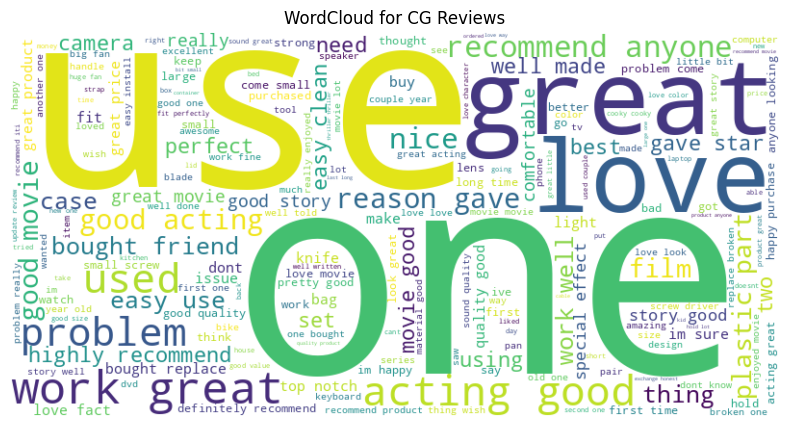

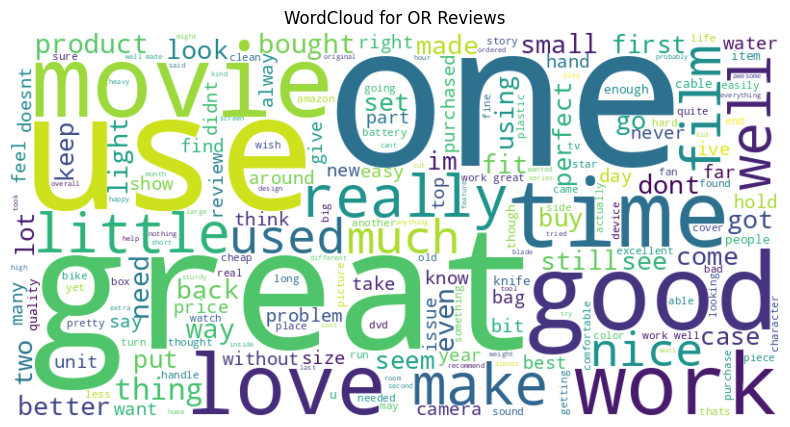

In [12]:
# WordCloud for each class
for label in df['label'].unique():
    text = ' '.join(df[df['label'] == label]['cleaned_text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'WordCloud for {label} Reviews')
    plt.axis('off')
    plt.show()

# Bigrams visualization
def get_bigrams(text):
    tokens = word_tokenize(text)
    bigrams = list(nltk.bigrams(tokens))
    return [' '.join(bigram) for bigram in bigrams]

fake_bigrams = Counter(get_bigrams(' '.join(df[df['label'] == 'CG']['cleaned_text'])))
real_bigrams = Counter(get_bigrams(' '.join(df[df['label'] == 'OR']['cleaned_text'])))

<Figure size 1200x600 with 0 Axes>

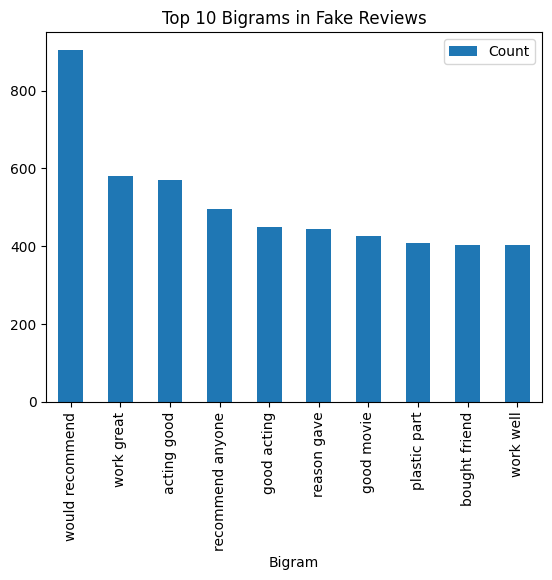

<Figure size 1200x600 with 0 Axes>

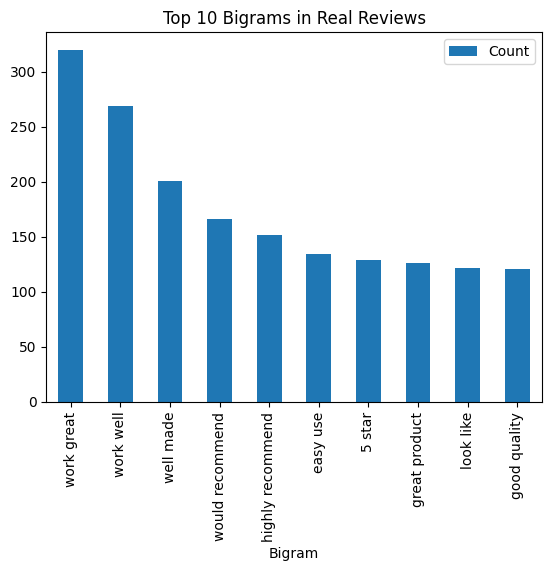

In [13]:
# Plot top 10 bigrams
plt.figure(figsize=(12, 6))
pd.DataFrame(fake_bigrams.most_common(10), columns=['Bigram', 'Count']).plot(kind='bar', x='Bigram', y='Count', title='Top 10 Bigrams in Fake Reviews')
plt.show()
plt.figure(figsize=(12, 6))
pd.DataFrame(real_bigrams.most_common(10), columns=['Bigram', 'Count']).plot(kind='bar', x='Bigram', y='Count', title='Top 10 Bigrams in Real Reviews')
plt.show()

In [14]:
# === 3. Text Vectorization ===

# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(df['cleaned_text']).toarray()
y = df['label_encoded']

# Analyze vectorization
print(f"TF-IDF Matrix Shape: {X.shape}")
print(f"Vocabulary Size: {len(tfidf.vocabulary_)}")
print(f"Memory Usage (MB): {X.nbytes / 1024 / 1024:.2f}")

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

TF-IDF Matrix Shape: (18208, 5000)
Vocabulary Size: 5000
Memory Usage (MB): 694.58


In [15]:
# === 4. Modeling ===

# Logistic Regression
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)
lr_prob = lr_model.predict_proba(X_test)[:, 1]

# MLP Classifier
mlp_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
mlp_model.fit(X_train, y_train)
mlp_pred = mlp_model.predict(X_test)
mlp_prob = mlp_model.predict_proba(X_test)[:, 1]

In [ ]:
# === 5. Evaluation ===

# Evaluation metrics
def evaluate_model(y_true, y_pred, y_prob, model_name):
    print(f"\n{model_name} Performance:")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"Recall: {recall_score(y_true, y_pred):.4f}")
    print(f"F1-Score: {f1_score(y_true, y_pred):.4f}")
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    print(f"AUC: {auc(fpr, tpr):.4f}")

evaluate_model(y_test, lr_pred, lr_prob, "Logistic Regression")
evaluate_model(y_test, mlp_pred, mlp_prob, "MLP Classifier")

In [ ]:
# ROC Curve
plt.figure(figsize=(8, 6))
for model_name, y_prob in [("Logistic Regression", lr_prob), ("MLP Classifier", mlp_prob)]:
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc(fpr, tpr):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# Confusion Matrix
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for ax, y_pred, model_name in zip(axes, [lr_pred, mlp_pred], ["Logistic Regression", "MLP Classifier"]):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', ax=ax)
    ax.set_title(f'Confusion Matrix: {model_name}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
plt.tight_layout()
plt.show()

In [ ]:
# Qualitative error analysis
errors = X_test[y_test != lr_pred]
error_indices = y_test.index[y_test != lr_pred]
print("\nSample Misclassified Reviews (Logistic Regression):")
for idx in error_indices[:2]:
    print(f"Review: {df.loc[idx, 'text']}")
    print(f"True Label: {df.loc[idx, 'label']}, Predicted: {'real' if lr_pred[y_test.index.get_loc(idx)] == 1 else 'fake'}\n")

In [ ]:
# === 6. Interpretation with LIME ===

# Select the better performing model (assume Logistic Regression for simplicity)
explainer = LimeTextExplainer(class_names=['fake', 'real'])

# Function to predict probabilities for LIME
def predict_proba(texts):
    cleaned_texts = [clean_text(text) for text in texts]
    tfidf_texts = tfidf.transform(cleaned_texts).toarray()
    return lr_model.predict_proba(tfidf_texts)

# Explain two reviews
print("\nLIME Explanations for Two Reviews:")
for idx in y_test.index[:2]:
    review = df.loc[idx, 'text']
    exp = explainer.explain_instance(review, predict_proba, num_features=6)
    print(f"\nReview: {review}")
    print(f"True Label: {df.loc[idx, 'label']}")
    print("Influential Words:")
    for feature, weight in exp.as_list():
        print(f"{feature}: {weight:.4f}")
    exp.show_in_notebook()  # Uncomment if running in Jupyter

# === 7. Theoretical Questions ===

# 1. Why is text cleaning crucial before vectorization?

Text cleaning is essential because raw text contains noise (e.g., punctuation, stopwords, inconsistent cases) that can distort the meaning and inflate vocabulary size, leading to inefficient and less accurate models. Cleaning standardizes the text, reduces dimensionality, and ensures that the vectorization captures meaningful patterns.


# 2. What does the F1-score measure, and why is it often more relevant than accuracy?

The F1-score is the harmonic mean of precision and recall, balancing the trade-off between false positives and false negatives. It is more relevant than accuracy in imbalanced datasets (e.g., more real than fake reviews), as accuracy can be misleadingly high if the model predicts the majority class well but fails on the minority class.


# 3. What is the difference between TF-IDF and embeddings like Word2Vec?

TF-IDF is a statistical measure that weights words based on their frequency in a document relative to a corpus, producing sparse vectors. Word2Vec creates dense, low-dimensional embeddings that capture semantic relationships (e.g., synonyms) using neural networks. TF-IDF is simpler and effective for small datasets, while Word2Vec is better for capturing context but requires more data and computation.


# 4. How can class imbalance impact model performance?

Class imbalance can bias models toward the majority class, leading to high accuracy but poor performance on the minority class (e.g., failing to detect fake reviews). It reduces recall and F1-score for the minority class, as the model may underfit the minority class patterns. Techniques like oversampling, undersampling, or class weighting can mitigate this.


# 5. What are the ethical issues related to automated detection of fraudulent content?

Ethical issues include:
- False positives: Mislabeling genuine reviews as fake can harm honest users or businesses.
- Bias: Models trained on biased data may unfairly target specific groups or products.
- Privacy: Analyzing user reviews may involve sensitive data, raising consent concerns.
- Transparency: Users and businesses should understand how decisions are made, requiring interpretable models.
- Misuse: Automated systems could be exploited to suppress legitimate criticism or manipulate markets.
